In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import RegularPolygon
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval
from adjustText import adjust_text

# First time we use seaborn
import seaborn as sns

from mplsoccer import Pitch, VerticalPitch, lines

from PIL import Image
import urllib
import os

from math import acos, pi
from scipy.stats import circmean


In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager
from seleniumbase import Driver

import time
import json

# options = Options()
# options.headless = False

# driver = webdriver.Chrome(options=options,service=ChromeService(ChromeDriverManager().install()))

In [5]:
plt.style.use("../../assets/stylesheets/soc_base.mplstyle")

Get Match Events v2

In [32]:
def san_array(x):
    j = []
    for u in x:        
        if len(u):
            if "value" in u.keys():
                j.append({u["type"]["displayName"]:u["value"]})
            # else:
            #     j.append({u["type"]["displayName"]:"True"})
    return json.dumps(j)

def check_null(key, dict):
    try:
        y = dict[key]
    except:
        y = None
    return y

def get_match_events_v2(driver,match_id):
    whoscored_match_url = f'https://www.whoscored.com/Matches/{match_id}/Live/'
    driver.get(whoscored_match_url)

    scriptdiv = driver.find_elements(By.CSS_SELECTOR, 'script')

    indicator_string = 'matchCentreData'
    for i in range(len(scriptdiv)):
        jstring = scriptdiv[-1*(i+1)].get_attribute('innerHTML')
        if indicator_string in jstring:
            break
    jstring = jstring.replace('require.config.params["args"] = ', '')
    jstring = jstring.replace('\n', '')
    jstring = jstring.replace('            ', '')
    jstring = jstring.replace('{matchId:', '{"matchId":')
    jstring = jstring.replace('matchCentreData:', '"matchCentreData":')
    jstring = jstring.replace(
        'formationIdNameMappings', '"formationIdNameMappings"')
    jstring = jstring.replace(
        'matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    jstring = jstring.replace('};', '}')

    d = json.loads(jstring)
    matchData = d['matchCentreData']
    matchId = d['matchId']
    events = matchData['events']

    player_dict = d['matchCentreData']['playerIdNameDictionary']
    players = {
        'id': player_dict.keys(),
        'name': player_dict.values()
    }
    players_df = pd.DataFrame(players).reset_index()
    players_df['id'] = players_df['id'].astype(int)
    event_list = []
    for index, e in enumerate(events):
        ev = e

        try:
            player_id = int(ev['playerId'])
        except:
            player_id = None
        try:
            player_name = players_df[players_df['id'] == player_id]['name'].iloc[0]
        except:
            player_name = None
        print(player_name)

        home_id = matchData['home']['teamId']
        home_name = matchData['home']['name']
        away_id = matchData['away']['teamId']
        away_name = matchData['away']['name']

        teamName = None
        if (ev['teamId'] == home_id):
            teamName = home_name
        if (ev['teamId'] == away_id):
            teamName = away_name

        pass_recipient = None
        if index < len(events)-1:
            next_ev = events[index+1]
            if (ev['type']['displayName'] == 'Pass') & (ev['outcomeType']['displayName'] == 'Successful'):
                try:
                    pass_recipient = players_df[players_df['id'] == int(
                        next_ev['playerId'])]['name'].iloc[0]
                except:
                    pass_recipient = None

        event_list.append({
            'event_id': ev['eventId'],
            'minute': ev['minute'],
            'second': check_null('second', ev),
            'team_id': ev['teamId'],
            'x': ev['x'],
            'y': ev['y'],
            'expanded_minute': ev['expandedMinute'],
            'period': ev['period']['displayName'],
            'outcome_type': ev['outcomeType']['displayName'],
            'qualifiers': san_array(ev['qualifiers']),
            'satisfied_events_types': (ev['satisfiedEventsTypes']),
            'is_touch': ev['isTouch'],
            'player_id': player_id,
            'end_x': check_null('endX', ev),
            'end_y': check_null('endY', ev),
            'related_event_id': check_null('relatedEventId', ev),
            'related_player_id': check_null('relatedPlayerId', ev),
            'goal_mouth_z': check_null('goalMouthZ', ev),
            'goal_mouth_y': check_null('goalMouthY', ev),
            'is_shot': check_null('isShot', ev),
            'blocked_x': check_null('blockedX', ev),
            'blocked_y': check_null('blockedY', ev),
            'card_type': check_null('cardType', ev),
            'is_goal': check_null('isGoal', ev),
            'player_name': player_name,
            'event_type': ev['type']['displayName'],
            'pass_recipient': pass_recipient,
            'team_name': teamName,
            'match_date': matchData['timeStamp'],
            'match_id': matchId,
            'match_string': f"{home_name} - {away_name}"
        })

    event_df = pd.DataFrame(event_list)
    return {
        'data' : event_df,
        'home_id' : home_id,
        'home_name' : home_name,
        'away_id' : away_id,
        'away_name' : away_name,
    }

In [33]:
data = pd.read_csv('../../data/soc/fa_cup_solar.csv',
                   index_col=0, low_memory=False)
data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
# data['satisfied_events_types'] = [literal_eval(
    # x) for x in data['satisfied_events_types']]

In [51]:
# scrape match event data
driver = Driver(browser="chrome")
d = get_match_events_v2(driver,1705071)
data = d['data']
driver.quit()

data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]

None
None
Eddie Nketiah
Matt Turner
Rodri
Thomas Partey
Rob Holding
Kieran Tierney
Gabriel Magalhães
Matt Turner
Ilkay Gündogan
Manuel Akanji
Thomas Partey
Kevin De Bruyne
Thomas Partey
Stefan Ortega
Rob Holding
Erling Haaland
Rob Holding
Rico Lewis
Rodri
Rodri
Stefan Ortega
Riyad Mahrez
Gabriel Magalhães
Kevin De Bruyne
Kieran Tierney
Leandro Trossard
Gabriel Magalhães
Matt Turner
Rob Holding
Takehiro Tomiyasu
Bukayo Saka
Takehiro Tomiyasu
Matt Turner
Thomas Partey
Rob Holding
Takehiro Tomiyasu
Matt Turner
Ilkay Gündogan
Ilkay Gündogan
Kevin De Bruyne
Erling Haaland
Kevin De Bruyne
Erling Haaland
Rodri
Matt Turner
Gabriel Magalhães
Eddie Nketiah
Nathan Aké
Nathan Aké
Stefan Ortega
Ilkay Gündogan
Jack Grealish
Nathan Aké
Jack Grealish
Rodri
Manuel Akanji
Rico Lewis
Manuel Akanji
Stefan Ortega
Rob Holding
Erling Haaland
Rob Holding
Riyad Mahrez
Gabriel Magalhães
Gabriel Magalhães
Gabriel Magalhães
Leandro Trossard
Takehiro Tomiyasu
Stefan Ortega
Riyad Mahrez
Kieran Tierney
Riyad Mahrez


Compute Angles & Circular Mean


In [52]:
df = data[data['outcome_type'] == 'Successful'].reset_index(drop=True)

df.loc[:, 'is_open_play'] = True
for index, record in enumerate(df['qualifiers']):
    for attr in record:
        key_search = list(attr.keys())[0]
        if key_search in ['GoalKick', 'FreekickTaken', 'CornerTaken', 'Throwin']:
            df.at[index, 'is_open_play'] = False
df = df[df['is_open_play']].reset_index(drop=True)

df = df.assign(dx=lambda x: x.end_x - x.x)
df = df.assign(dy=lambda x: x.end_y - x.y)
df = df.assign(length_pass=lambda x: (x.dx**2 + x.dy**2)**(1/2))

df['angle'] = [acos(dx/length_pass)
               for dx, length_pass in zip(df['dx'], df['length_pass'])]
df['angle'] = [pi + angle if dy < 0 else angle for angle,
               dy in zip(df['angle'], df['dy'])]

In [53]:
home_passes = df[df['team_name'] == d['home_name']].reset_index(drop=True)
away_passes = df[df['team_name'] == d['away_name']].reset_index(drop=True)

# Home
home_angle = home_passes.groupby(['pass_recipient']).apply(
    lambda x: circmean(x.angle)).reset_index(name='angle')
home_length = home_passes.groupby(['pass_recipient'])[
    'length_pass'].mean().reset_index()
home_size = home_passes.groupby(['pass_recipient'])[
    'match_id'].size().reset_index(name='num_passes')
home_summary = pd.merge(home_angle, home_length, on='pass_recipient')
home_summary = pd.merge(home_summary, home_size, on='pass_recipient')

#  Away
away_angle = away_passes.groupby(['pass_recipient']).apply(
    lambda x: circmean(x.angle)).reset_index(name='angle')
away_length = away_passes.groupby(['pass_recipient'])[
    'length_pass'].mean().reset_index()
away_size = away_passes.groupby(['pass_recipient'])[
    'match_id'].size().reset_index(name='num_passes')
away_summary = pd.merge(away_angle, away_length, on='pass_recipient')
away_summary = pd.merge(away_summary, away_size, on='pass_recipient')

away_summary['annotate'] = [True if x > away_summary['num_passes']
                          .quantile(.35) else False for x in away_summary['num_passes']]
home_summary['annotate'] = [True if x > home_summary['num_passes']
                          .quantile(.35) else False for x in home_summary['num_passes']]


Pass Solar


In [54]:
def plot_fancy_polar(ax):
    # Remove tick and label
    ax.set_thetalim(0, 2*np.pi)
    ax.set_rlim(0, 35)
    ax.set_xticks([])
    ax.set_xticklabels([])
    # Aux computation
    ax.set_yticks(np.linspace(0, 40, 9))
    ax.set_yticklabels([])
    ax.tick_params("both",
                   grid_alpha=0.50,
                   grid_zorder=-10,
                   grid_linewidth=0.5)
    ax.set_ylabel(None)
    # Draw angle ticks
    radius = ax.get_rmax()
    length = 0.05 * radius
    for i in range(360):
        angle = np.pi*i/180
        ax.plot(
            [angle, angle],
            [radius, radius-length],
            linewidth=0.50,
            color="0.75",
            clip_on=False,
        )
    for i in range(0, 360, 5):
        angle = np.pi*i/180
        ax.plot(
            [angle, angle],
            [radius, radius-2*length],
            linewidth=0.75,
            color="0.75",
            clip_on=False,
        )
    # Draw edges and add annotations
    for i in range(0, 360, 90):
        angle = np.pi*i/180
        ax.plot(
            [angle, angle],
            [radius, 0],
            zorder=3,
            linewidth=1.00,
            color="gray"
        )
        if i == 0:
            text_ = 'Opposition goal'
        elif i == 90:
            text_ = 'Left'
        elif i == 180:
            text_ = 'Own goal'
        else:
            text_ = 'Right'
        ax.text(
            angle,
            radius+4*length,
            text_,
            zorder=3,
            rotation=i-90,
            rotation_mode="anchor",
            va="top",
            ha="center",
            size="x-small",
            family="Georgia",
            color="black"
        )
    # Radius ticks
    length = .5*length

    def polar_to_cartesian(theta, radius):
        x = radius*np.cos(theta)
        y = radius*np.sin(theta)
        return np.array([x, y])

    def cartesian_to_polar(x, y):
        radius = np.sqrt(x**2+y**2)
        theta = np.arctan2(y, x)
        return np.array([theta, radius])

    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0)+[0, 0.75*length]))
        ax.plot([P0[0],P1[0]], [P0[1],P1[1]],linewidth=0.50,color="gray")
        
    for i in range(0,40,5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0)+[0,+1.0*length]))
        ax.plot([P0[0],P1[0]],[P0[1],P1[1]],zorder=3,linewidth=0.75,color="gray")
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0)+[0,-1.0*length]))
        text=ax.text(
            P1[0],
            P1[1],
            f'{i*1.15:.0f}',
            zorder=3,
            va="top",
            ha="center",
            size="xx-small",
            family="Georgia",
            color="gray",
        )
        text.set_path_effects([path_effects.Stroke(linewidth=2,foreground="white"),path_effects.Normal()])
    # Circular bands
    n=35
    T=np.linspace(0,2*np.pi,n)
    color_even = "0.95"
    increase_size = 35/7
    cutoff=0
    while cutoff <=35:
        if cutoff%2 ==0:
            color=color_even
            ax.fill_between(T,cutoff,cutoff+increase_size,color=color_even,zorder=-50)
        cutoff+=increase_size
    ax.scatter([0],[0],20,facecolor="white",edgecolor="gray",zorder=1000)

(-0.5, 191.5, 191.5, -0.5)

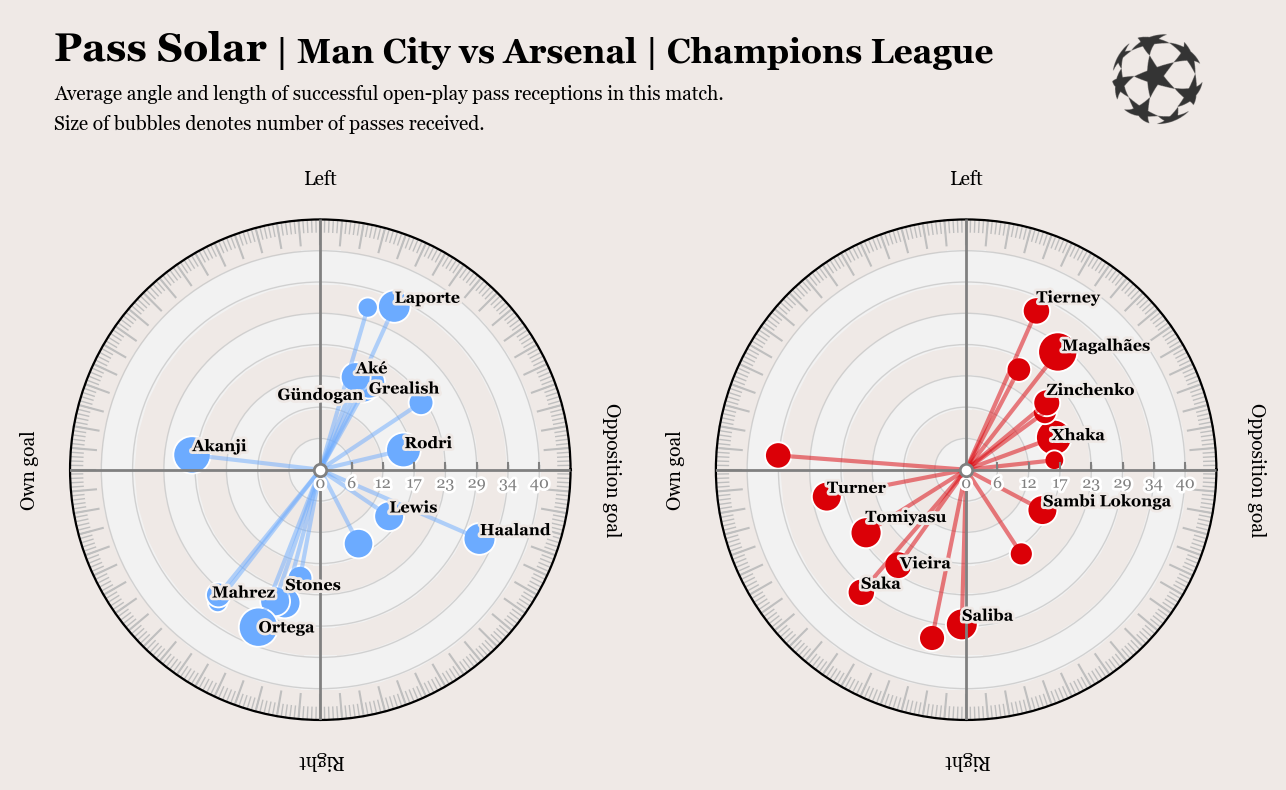

In [55]:
fig = plt.figure(dpi=200)
ax_home = plt.subplot(1, 2, 1, projection="polar", frameon=True)
ax_away = plt.subplot(1, 2, 2, projection="polar", frameon=True)

comp = [
    {'id':47,'name':'Premier League'},
    {'id':42,'name':'Champions League'}
]
idn = 1
competition_name = comp[idn]['name']
competition_id = comp[idn]['id']

home_color = '#6CABFF'
away_color = '#DB0007'

# Home
plot_fancy_polar(ax_home)
sns.scatterplot(
    data=home_summary,
    x='angle',
    y='length_pass',
    color=home_color,
    size='num_passes',
    sizes=(50, 200),
    legend=False,
    ax=ax_home,
    zorder=2
)
ax_home.set_ylabel(None)
texts = []
annotate_home = home_summary[home_summary['annotate']]
for index in range(annotate_home.shape[0]):
    player_name = annotate_home['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_home.text(
            x=annotate_home['angle'].iloc[index],
            y=annotate_home['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[
                path_effects.Stroke(
                    linewidth=2, foreground=fig.get_facecolor()),
                path_effects.Normal()
            ],
            color='black',
            family='Georgia',
            weight='bold',
            size='xx-small',
            zorder=10
        )
    ]

for index,length in enumerate(home_summary['length_pass']):
    ax_home.plot(
        [0,home_summary['angle'].iloc[index]],
        [0,length],
        zorder=2,
        alpha=.5,
        color=home_color
    )
adjust_text(texts,precision=5.25,expand_text=(.5,4),ax=ax_home)

# Arsenal
plot_fancy_polar(ax_away)
sns.scatterplot(
    data=away_summary,
    x='angle',
    y='length_pass',
    color=away_color,
    size='num_passes',
    sizes=(50, 200),
    legend=False,
    ax=ax_away,
    zorder=2
)
ax_away.set_ylabel(None)
texts = []
annotate_ar = away_summary[away_summary['annotate']]
for index in range(annotate_ar.shape[0]):
    player_name = annotate_ar['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_away.text(
            x=annotate_ar['angle'].iloc[index],
            y=annotate_ar['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[
                path_effects.Stroke(
                    linewidth=2, foreground=fig.get_facecolor()),
                path_effects.Normal()
            ],
            color='black',
            family='Georgia',
            weight='bold',
            size='xx-small',
            zorder=10
        )
    ]

for index,length in enumerate(away_summary['length_pass']):
    ax_away.plot(
        [0,away_summary['angle'].iloc[index]],
        [0,length],
        zorder=2,
        alpha=.5,
        color=away_color
    )
adjust_text(texts,precision=5.25,expand_text=(.5,4),ax=ax_away)

plt.subplots_adjust(wspace=.25,hspace=-.5)

fig_text(
    x=.12,
    y=1.14,
    s=f"<Pass Solar> | {d['home_name']} vs {d['away_name']} | {competition_name}",
    family='Georgia',
    ha='left',
    va='center',
    weight='bold',
    size='large',
    highlight_textprops=[{'weight':'bold','size':'x-large'}]
)

fig_text(
    x=.12,
    y=1.05,
    s='Average angle and length of successful open-play pass receptions in this match.\nSize of bubbles denotes number of passes received.',
    family='Georgia',
    ha='left',
    va='center',
    size='x-small'
)

image_ax = fig.add_axes(
    [.78,1.02,.15,.15],
    fc='None'
)
fotmob_url = f'https://images.fotmob.com/image_resources/logo/leaguelogo/{competition_id}.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
image_ax.imshow(club_icon)
image_ax.axis('off')
